In [41]:
#import libaries and data directory
import pandas as pd
import os
import selenium
from selenium import webdriver
import io
import requests
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import ElementClickInterceptedException
import string
import time
import os
import matplotlib.pyplot as plt
import pretty_midi

# 1) Data Collection representativeness
## a) Getting a billboard MIDI dataset  
To answer the question if more popular songs use a Tresillio like rhythm, we have to collect a data set which represents popular songs. Thus, we chose to dowload MIDI files of top 20 weekly billboard charts.  
In this first part we are loadig a data set of the ['Hot weekly Billboard charts'](https://data.world/kcmillersean/billboard-hot-100-1958-2017), which gives us information about billboard charts (songs) from 1999-2019. Given this data set we then can collect MIDI files, which encode the mentioned billboard songs. 
However, before getting the MIDI files we have to reduce and filter the weekly charts data set, given that it first of all includes many non unique songs (songs that stay on the charts for several weeks) and given that the number of songs in huge.



In [22]:
df_billboard = pd.read_csv('billboardHot100_1999-2019.csv')#consist out of 97'225 NOT unique songs

#Take only the top position of a song
df_billboard_best_position = df_billboard[df_billboard['Peak.position'] == df_billboard['Weekly.rank']]
print(len(df_billboard_best_position))# 33950

#Lets only take songs which are min top 20
df_billboard_selection = df_billboard_best_position[df_billboard_best_position['Peak.position'] <=20]

#Delete duplicates: Song several weeks on same chart place 
df_billboard_selection = df_billboard_selection.sort_values('Week', ascending=True).drop_duplicates('Name')
df_billboard_selection = df_billboard_selection.drop(axis=0, columns=['Unnamed: 0'])
print(len(df_billboard_selection)) # 1447, seems like a good lenght for an initial data analysis 

df_billboard_selection.to_csv(dataset_root+'billboard_1999-2019_unique_top_20_selection.csv', index=False)

df_billboard_selection.head(5)

33950
1447


,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features
97148,Sarah McLachlan,I Will Remember You,18,18.0,29.0,1999-07-12,NaN,"Pop,Rock","Dave merenda, Seamus egan, Sarah mclachlan",I Will Remember You \nI will remember you\nWil...,NaN
97134,Destiny's Child,"Bills, Bills, Bills",1,1.0,5.0,1999-07-12,NaN,"R&;B,Rap","Beyonce, Destinys child, Kandi, Kevin sheksper...","Bills, Bills, Bills \nAt first we started out ...",NaN
97141,Smash Mouth,All Star,10,10.0,9.0,1999-07-12,NaN,"Punk Rock,Ska,Ska Punk,Screen,Pop-Rock,Soundtr...",Greg camp,All Star \nSomebody once told me the world is ...,NaN
97139,Backstreet Boys,I Want It That Way,6,6.0,13.0,1999-07-12,NaN,"Rap,Boy Band,Pop","Andreas carlsson, Max martin",I Want It That Way \nYeah\nYou are my fire\nTh...,NaN
97137,Christina Aguilera,Genie In A Bottle,4,4.0,3.0,1999-07-12,NaN,"Dance-Pop,Pop","David frank, Steve kipner, Pamela sheyne","Genie in a Bottle \nCome on, come on\nUh, yeah...",NaN


In [5]:
#We reduced our data set to only 1447 songs, of which we can no search the MIDI files
df_billboard_top_20 = pd.read_csv('billboard_1999-2019_unique_top_20_selection.csv')
df_billboard_top_20[['Name', 'Artists']].head(5)

,Name,Artists
0,I Will Remember You,Sarah McLachlan
1,"Bills, Bills, Bills",Destiny's Child
2,All Star,Smash Mouth
3,I Want It That Way,Backstreet Boys
4,Genie In A Bottle,Christina Aguilera


## b) Scrapping MIDI files
We searched quite extensively for curated bigger data sets,  which contain billboard songs. Sadly, we could only find data sets which contain billboard charts pre 2010 (e.g.: [Lakh MIDI Dataset](https://colinraffel.com/projects/lmd/)). 
However, given that we were especially intersted in more recent pop songs (post 2010), we decided that we will try to collect our own data set.  
To obtain MIDI files of billboard charts we decided to scrape songs from the website [MIDIdb](https://www.mididb.com/genres/). MIDIdb provides free MIDI samples of a big selection of songs (especially pop songs). Those samples encode around 45 seconds of the beginning of a given song. This is a bias in our data which we have to keep in mind.

In [11]:
#Given limited storage capacity the code below has been excetude on a local machine
def tiny_file_rename(newname, folder_of_download, time_to_wait=0.5):
  #This function renames a (MIDI) file which has just been downloaded
    time_counter = 0
    filename = max([f for f in os.listdir(folder_of_download)], key=lambda xa :   os.path.getctime(os.path.join(folder_of_download,xa)))
    while '.part' in filename:
        time.sleep(1)
        time_counter += 1
        if time_counter > time_to_wait:
            raise Exception('Waited too long for file to download')
    filename = max([f for f in os.listdir(folder_of_download)], key=lambda xa :   os.path.getctime(os.path.join(folder_of_download,xa)))
    os.rename(os.path.join(folder_of_download, filename), os.path.join(folder_of_download, newname))


#Here, I activate selenium and I set my dowload location 
chromeOptions = webdriver.ChromeOptions()
download_folder = "/home/nulpe/Desktop/Tresillo/dataset/billboard_mididb_files"
prefs = {"download.default_directory" : download_folder}
chromeOptions.add_experimental_option("prefs",prefs)
driver = webdriver.Chrome(executable_path='/usr/bin/chromedriver', options=chromeOptions)

#We download the songs given information about the artist and the name of the song
song_names_artists = [tuple(x) for x in df_billboard_top_20[['Name', 'Artists']].values]
base_url = 'https://www.mididb.com/search.asp?q=' 


#keep in check which songs have been dowloaded and which not
n_downloaded = 0
dowloaded_midi_db_bool = []


for idx, song_name_artist in enumerate(song_names_artists):
    
    #No punctuation in song or artit name
    song_name = song_name_artist[0].translate(str.maketrans('', '', string.punctuation)) #strip punctuation
    artist_name = song_name_artist[1].translate(str.maketrans('', '', string.punctuation)) #strip punctuation
    
    #That's the url we need for finding the song
    url_string = base_url + '+'.join(song_name.split())+'+'+'+'.join(artist_name.split())+'&formatID=1'
    
    #get the url code of the website and find the dowload page link
    driver.get(url_string)
    htlm_source = driver.page_source.split('\n')
    dowload_lines = [el for el in htlm_source if '" style="text-decoration:underline;"' in el]
    
    #If there is a search result take the first result (most likely match)
    if len(dowload_lines)>0:
        dowload_line = dowload_lines[0]
        download_page = dowload_line[dowload_line.find('<a href="')+9:dowload_line.find('" style="text-decoration:underline')]
        driver.get(download_page)
        htlm_source = driver.page_source.split('\n')
        dowload_midi = [el for el in htlm_source if 'Download MIDI' in el][0]
        dowload_midi = dowload_midi[dowload_midi.find('href="')+6:dowload_midi.find('">Download')]
        
        #save and rename the song with the song and artist name
        midi_file = driver.get(dowload_midi)
        time.sleep(0.5)
        tiny_file_rename(song_name+'_'+artist_name+'.midi', download_folder)
        
        #keep track of which songs we have dowloaded
        n_downloaded+=1
        dowloaded_midi_db_bool.append(1)
        
        #to monitor progress
        if n_downloaded%50 == 0:
            print(song_name, '   song number: ', 1+n_downloaded)
            
    else: dowloaded_midi_db_bool.append(0)

        

Dance With Me    song number:  51
Miss You    song number:  101
Lonely No More    song number:  151
Rockstar    song number:  201
Cowboy Casanova    song number:  251
Paradise    song number:  301
Holy Grail    song number:  351
Shut Up And Dance    song number:  401
God Is A Woman    song number:  451


## c) Analyzing the representativeness of the collected data  
We dowloaded  456  songs, which is about  31.5%  of our whole dataset.  
Below, we try to determine if the collected MIDI billboard sample is representative of the top 20 billboards between 1999 and 2019.  
Thus we compare certain distributions of the downloaded/available MIDI files, and the complete billboard data.


we dowloaded  456  songs, which is about  0.3151347615756738  of our whole dataset


Text(0, 0.5, 'Count')

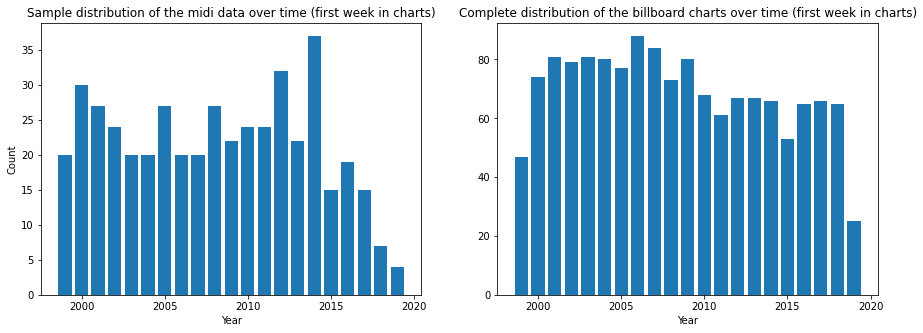

In [36]:
#Let's explore the data set and see if it is representative of the selected billboard charts
df_billboard_top_20 = pd.read_csv('billboard_1999-2019_unique_top_20_selection.csv')
df_billboard_top_20['Dowloaded'] = dowloaded_midi_db_bool
df_billboard_top_20['year'] = pd.DatetimeIndex(df_billboard_top_20.Week).year


print('we dowloaded ', sum(dowloaded_midi_db_bool),' songs, which is about ',sum(dowloaded_midi_db_bool)/len(df_billboard_top_20), ' of our whole dataset')

#save the df with download information 
df_billboard_top_20_dowloaded = df_billboard_top_20[df_billboard_top_20['Dowloaded']==1]
df_billboard_top_20_dowloaded.to_csv('billboard_1999-2019_top_20_downloaded.csv')

#let's compare songs per year with each other
df_billboard_top_20_dowloaded_per_year = df_billboard_top_20_dowloaded.groupby(['year'])['Name'].aggregate(['count']).reset_index()
df_billboard_top_20_per_year = df_billboard_top_20.groupby(['year'])['Name'].aggregate(['count']).reset_index()

#lets plot it 
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].bar(df_billboard_top_20_dowloaded_per_year.year, df_billboard_top_20_dowloaded_per_year['count'])
axs[1].bar(df_billboard_top_20_per_year.year, df_billboard_top_20_per_year['count'])
axs[0].set_title('Sample distribution of the midi data over time (first week in charts)')
axs[1].set_title('Complete distribution of the billboard charts over time (first week in charts)')
axs[0].set_xlabel('Year')
axs[1].set_xlabel('Year')
axs[0].set_ylabel('Count')


**Discussion:**  
There seem to be some differences between the complete distribution and the sample distribution. E.g.: very recent songs are often not avaiable.  
However, it seems to be a good enough 'guess' of the whole data. 

Text(0, 0.5, 'Count')

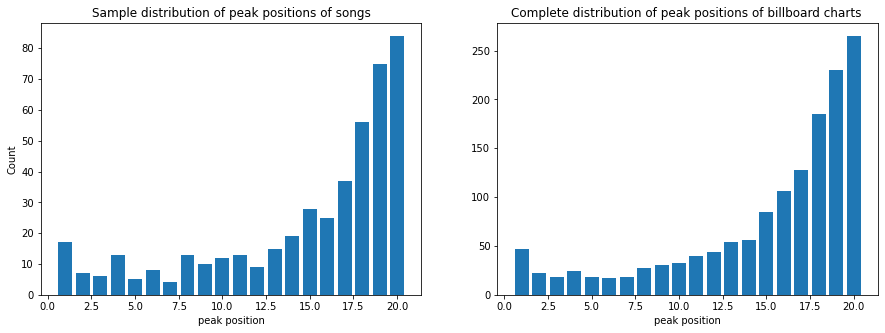

In [38]:
#lets plot the distribution of the peak positions of the songs in both data sets 
df_distribution_dowloaded_peak_positions = df_billboard_top_20_dowloaded.groupby(['Peak.position'])['Name'].aggregate(['count']).reset_index()
df_distribution__peak_positions = df_billboard_top_20.groupby(['Peak.position'])['Name'].aggregate(['count']).reset_index()

#lets plot it 
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].bar(pd.to_numeric(df_distribution_dowloaded_peak_positions['Peak.position']), df_distribution_dowloaded_peak_positions['count'])
axs[1].bar(df_distribution__peak_positions['Peak.position'], df_distribution__peak_positions['count'])
axs[0].set_title('Sample distribution of peak positions of songs')
axs[1].set_title('Complete distribution of peak positions of billboard charts ')
axs[0].set_xlabel('peak position')
axs[1].set_xlabel('peak position')
axs[0].set_ylabel('Count')

**Discussion:**  
Those distributions seem to match very closely. Meaning in our data set  are not more 'popular' songs then in the full distribution.  
*note: My guess is, there are significantly more songs with peak position nr. 20, because it is 'easier to get to position 20 then position 1*

Text(0, 0.5, 'Count')

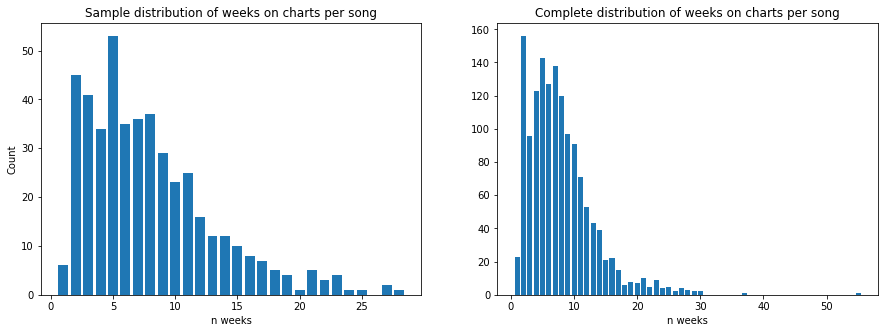

In [40]:
#lets plot weeks on charts 
df_distribution_dowloaded_week_on_chart = df_billboard_top_20_dowloaded.groupby(['Weeks.on.chart'])['Name'].aggregate(['count']).reset_index()
df_billboard_week_on_chart = df_billboard_top_20.groupby(['Weeks.on.chart'])['Name'].aggregate(['count']).reset_index()


#lets plot it 
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].bar(df_distribution_dowloaded_week_on_chart['Weeks.on.chart'], df_distribution_dowloaded_week_on_chart['count'])
axs[1].bar(df_billboard_week_on_chart['Weeks.on.chart'], df_billboard_week_on_chart['count'])
axs[0].set_title('Sample distribution of weeks on charts per song')
axs[1].set_title('Complete distribution of weeks on charts per song')
axs[0].set_xlabel('n weeks')
axs[1].set_xlabel('n weeks')
axs[0].set_ylabel('Count')

**Discussion:**  
Our sample seems to miss some outliers.

In [43]:
#Let's also look quickly look at the dowloaded midi files. How long are they in average? 
list_midis = os.listdir(download_folder)

length_midis = []


for el in list_midis:
    midi_data = pretty_midi.PrettyMIDI(download_folder+'/'+el)
    length_midis.append(midi_data.get_end_time())

print(sum(length_midis)/len(length_midis))
    
    

44.02126228501873


**Discussion:**  
The songs we dowloaded are only samples, e.i.: Around 45 sec of the beginning of the song.  
This is a clear bias and we have to take this in account!

### Fazit: Billboard data set
We downloaded a sample of the top 20 billboard songs from 1999-2019.  
In many respects this sample seems to be a good approximation of the complete data set. However, we will have to keep in mind that there might be inherent sampling bias.  
Furthermore, it is very important to note that our midi files only contain the beginning of our songs (around 45 seconds)

## d) Other data sets
In extend to the billboard data set we collect two more small data sets:  
- I) Tresillio MIDI data set: This small data set consist of a few (at the moment 10) hand selected songs which (for us) characterize the Tresillio rhythm. Those songs will aid us to computationally define 'Tresillio-ness'. E.i.: Give us a distribution of how a Tresillio rhythm might look like. Given this distribution we can then calculate how similar a given rhythm is to the Tresillio rythm. 
- II) Reference MIDI data set: A data set of some selected songs which certainly do not include the Tresillio rhythm. This reference corpus will serve us as a comparison corpus to the Tresillio data set. 

# 2) Data Format

# 3) Exploratory analysis, Discussion & Next Steps